# FINAL ML MODEL

In [135]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

path = os.getcwd()
os.chdir(path)

In [136]:
train = pd.read_csv('train.csv', sep=';',index_col= [0])
test = pd.read_csv('test.csv', sep=';',index_col= [0])
grid_locations2 = pd.read_csv('grid_locations_processed.csv', sep=';',index_col= [0])
baseloads = pd.read_csv('baseloads.csv',sep=';',index_col= [0])

## SOME MORE DATA PROCESSING

In [137]:
#for creating timestep sequences
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [138]:
#TRAIN
df2 = pd.DataFrame(columns=['public_chargers','home_chargers','time','present'])

for i in range(len(train)):
    seq = list(train.loc[i,[str(i) for i in range(24)]])
    steps = 0
    past_steps, present = split_sequence(seq, steps)
    #print(past_steps)
    for j in range(steps,24):
        
        row_df = list(train.loc[i,['public_chargers','home_chargers']].values)
        row_df.append(j) #time
        #row_df.append(past_steps[j-steps][0]) # t-3 load
        #row_df.append(past_steps[j-steps][0]) # t-2 load
        #row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df2.columns)
        df2 = df2.append(series, ignore_index= True) 

time_one_hot = pd.get_dummies(df2['time'])
df2 = df2.join(time_one_hot)



In [139]:
#TEST
df2_test = pd.DataFrame(columns=['cadaster','public_chargers','home_chargers','time','present'])

for i in range(len(test)):
    seq = list(test.loc[i,[str(i) for i in range(24)]])
    steps = 0
    past_steps, present = split_sequence(seq, steps)
    
    for j in range(steps,24):
        
        row_df = list(test.loc[i,['cadaster','public_chargers','home_chargers']].values)
        row_df.append(j) #time
        #row_df.append(past_steps[j-steps][0]) # t-3 load
        #row_df.append(past_steps[j-steps][0]) # t-2 load
        #row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df2_test.columns)
        df2_test = df2_test.append(series, ignore_index= True) 

time_one_hot = pd.get_dummies(df2_test['time'])
df2_test = df2_test.join(time_one_hot)


## FEATURES 

In [140]:
tunnused  = list(range(steps,24))
tunnused.append('public_chargers')
tunnused.append('home_chargers')
#tunnused.append('last_delta')
#tunnused.append('t-2')
#tunnused.append('t-1')

## RANDOM FOREST

In [141]:
rf = RandomForestRegressor(n_estimators=50)
rf.fit(df2[tunnused], df2['present'])
pred = rf.predict(df2_test[tunnused])

# negative values will be set to 0
pred[pred < 0] = 0

r2 = rf.score(df2_test[tunnused], df2_test['present']) 
rmse = mean_squared_error(df2_test['present'], pred, squared=False)

In [142]:
print('RMSE on test set: ',rmse,'R**2 score on test set: ',r2)

RMSE on test set:  11.102979746103646 R**2 score on test set:  0.40926996035912455


In [143]:
pred = pd.DataFrame(pred,columns=['ev_prediction'])
df2_test = df2_test.join(pred)
ennustused =  df2_test[['cadaster','time','ev_prediction']].copy()

## DATA FOR DASHBOARD + PREDICTION PLOTS

In [144]:
df3 = pd.DataFrame(columns=['cadaster','address','max_current','latitude','longitude','hour','ev_charge'])

for i in range(len(grid_locations2)):
    seq = list(grid_locations2.loc[i,[str(x) for x in range(0,24)]])
    steps = 0
    past_steps, present = split_sequence(seq, steps)
    
    for j in range(0,24):
        
        row_df = list(grid_locations2.loc[i,['cadaster','address','max_current','latitude','longitude']].values)
        row_df.append(j) #time
        #row_df.append(past_steps[j-steps][0]) # t-2 load
        #row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df3.columns)
        df3 = df3.append(series, ignore_index= True) 

In [145]:
baseloads = pd.DataFrame.from_dict(baseloads)
df3 = pd.merge(df3, baseloads.T, right_index=True, left_on='cadaster')

In [146]:
for index, row in df3.iterrows():
    df3.loc[index,0] = df3.loc[index,row['hour']]

df3 = df3.rename(columns={0: "baseload"})
df3.drop(range(1,24),axis= 'columns', inplace = True)

In [147]:
df3 = pd.merge(df3,ennustused,how = 'left', left_on = ['cadaster','hour'], right_on = ['cadaster','time'])

df3.loc[df3['ev_prediction'].isna(), 'time'] = True
df3.loc[~df3['ev_prediction'].isna() , 'time'] = False
df3 = df3.rename(columns={'time': "is_train"})

In [148]:
df3['combined_load'] = df3['ev_charge'] + df3['baseload']
df3['predicted_combined_load'] = df3['ev_prediction'] + df3['baseload']
df3 = df3.rename(columns={'ev_prediction': "predicted_ev_load"})
df3.to_csv("dashboard.csv", sep=";")

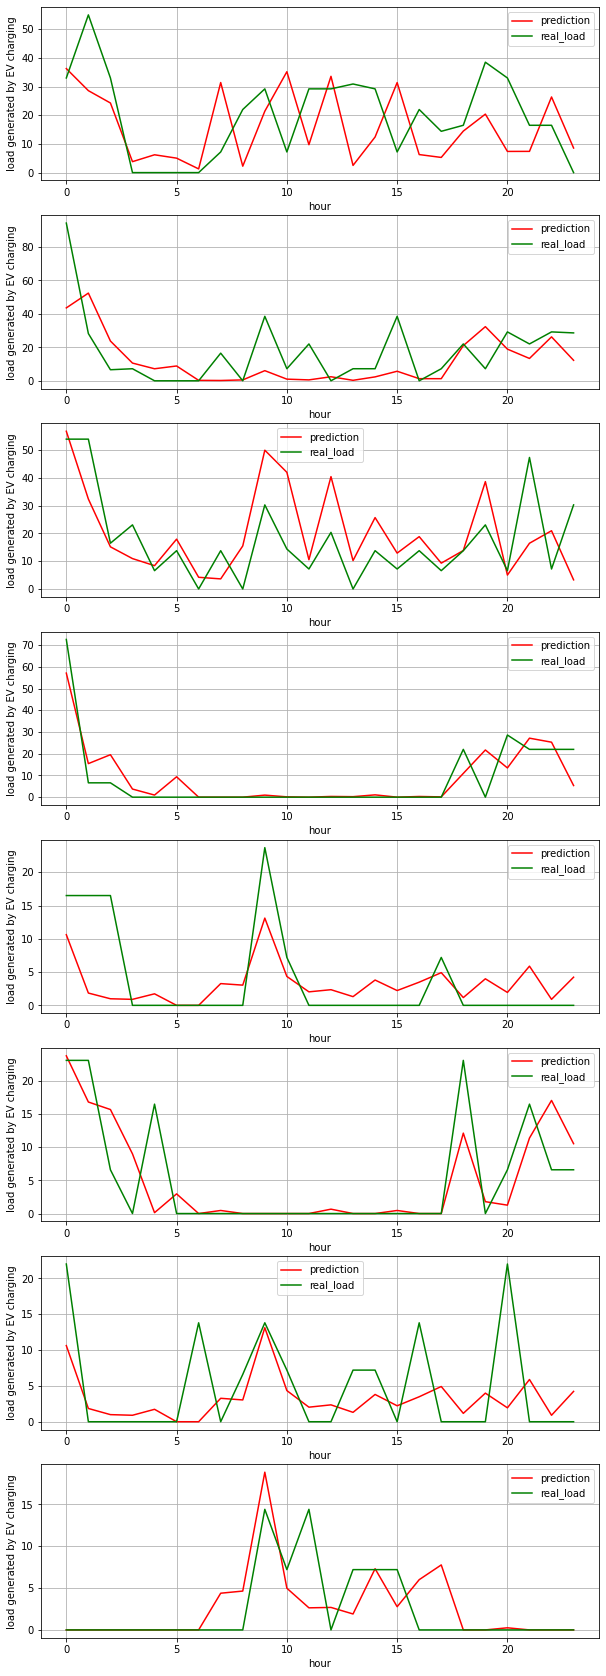

In [149]:
enn = df3.loc[df3['is_train'] == False].copy()
pred = enn.groupby('cadaster')['predicted_ev_load'].apply(list)
real = enn.groupby('cadaster')['ev_charge'].apply(list)

nrows = 8
fig, axes = plt.subplots(nrows, 1,figsize=(10,30),sharey='row')

for i,((key, value),row) in enumerate(zip(pred.items(),axes)):
    row.plot(pred[key], color='red',label = 'prediction')
    
    row.plot(real[key], color='green',label = 'real_load')
    #if i == 0:
    row.legend()
    row.set_xlabel('hour')
    row.set_ylabel('load generated by EV charging')
    row.grid(True)
    #plt.figure()
    #plt.plot(pred[key], label = 'prediction')
    #plt.plot(real[key],label = 'real_ev_charge')
    #plt.legend()
plt.show()